In [15]:
import tensorflow as tf
import fiftyone as fo
import fiftyone.zoo as foz

# Load the COCO-2017 dataset
# This will download it from the FiftyOne Dataset Zoo if necessary
dataset = foz.load_zoo_dataset("coco-2017", split="train", label_types=["detections"], classes=["person"], max_samples=3000)
dataset_test = foz.load_zoo_dataset("coco-2017", split="validation", label_types=["detections"], classes=["person"], max_samples=500)


Found annotations at 'C:\Users\angga\fiftyone\coco-2017\raw\instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Found annotations at 'C:\Users\angga\fiftyone\coco-2017\raw\instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'coco-2017-validation-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [20]:
print(dataset)
print(dataset.first())

Name:        coco-2017-train-300
Media type:  image
Num samples: 300
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
<Sample: {
    'id': '64c7ce84735d977371ab6696',
    'media_type': 'image',
    'filepath': 'C:\\Users\\angga\\fiftyone\\coco-2017\\train\\data\\000000000036.jpg',
    'tags': ['train'],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 481,
        'height': 640,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '64c7ce84735d977371ab6694',
       

In [29]:
import xml.etree.ElementTree as ET
import json
import os
import xmltodict

def json_to_xml(json_path, xml_path, image_folder_path, target_label="person"):
    with open(json_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    image_id_to_filename = {image['id']: image['file_name'] for image in images}
    image_id_to_annotations = {image['id']: [] for image in images}

    for ann in annotations:
        image_id = ann['image_id']
        image_id_to_annotations[image_id].append(ann)

    for image_id, filename in image_id_to_filename.items():
        image_path = os.path.join(image_folder_path, filename)
        image_annotations = image_id_to_annotations[image_id]

        root = ET.Element("annotation")

        folder = ET.SubElement(root, "folder").text = image_folder_path
        filename_xml = ET.SubElement(root, "filename").text = filename

        size = ET.SubElement(root, "size")
        width = ET.SubElement(size, "width").text = str(data['images'][0]['width'])
        height = ET.SubElement(size, "height").text = str(data['images'][0]['height'])
        depth = ET.SubElement(size, "depth").text = str(3)  # Assuming 3 channels for RGB images

        for ann in image_annotations:
            category_id = ann['category_id']
            category_name = [cat['name'] for cat in categories if cat['id'] == category_id][0]
            bbox = ann['bbox']

            if category_name == target_label:
                object_xml = ET.SubElement(root, "object")
                name = ET.SubElement(object_xml, "name").text = category_name
                bndbox = ET.SubElement(object_xml, "bndbox")
                xmin = ET.SubElement(bndbox, "xmin").text = str(bbox[0])
                ymin = ET.SubElement(bndbox, "ymin").text = str(bbox[1])
                xmax = ET.SubElement(bndbox, "xmax").text = str(bbox[0] + bbox[2])
                ymax = ET.SubElement(bndbox, "ymax").text = str(bbox[1] + bbox[3])

        if len(root.findall("object")) > 0:  # Only save the annotation if there is at least one "person" object
            tree = ET.ElementTree(root)
            tree.write(os.path.join(xml_path, os.path.splitext(filename)[0] + ".xml"))

# Example usage:
json_to_xml("train/labels.json", "train_xml/", "train/data/", target_label="person")
#json_to_xml("validation/labels.json", "validation_xml/", "validation/data/", target_label="person")


In [33]:
import os
import tensorflow as tf
import xmltodict

def create_tf_example(xml_path, image_folder_path, label_map):
    with open(xml_path) as f:
        xml_data = f.read()
    data_dict = xmltodict.parse(xml_data)

    filename = data_dict['annotation']['filename']
    image_path = os.path.join(image_folder_path, filename)

    with tf.io.gfile.GFile(image_path, 'rb') as fid:
        encoded_image_data = fid.read()

    image_format = b'jpg'  # Assuming your images are in JPG format

    width = int(data_dict['annotation']['size']['width'])
    height = int(data_dict['annotation']['size']['height'])

    xmins, ymins, xmaxs, ymaxs, class_ids = [], [], [], [], []

    objects = data_dict['annotation']['object']
    if not isinstance(objects, list):
        objects = [objects]

    for obj in objects:
        class_name = obj['name']
        if class_name in label_map:
            class_id = label_map[class_name]
            x_min = float(obj['bndbox']['xmin'])
            y_min = float(obj['bndbox']['ymin'])
            x_max = float(obj['bndbox']['xmax'])
            y_max = float(obj['bndbox']['ymax'])

            xmins.append(x_min / width)
            ymins.append(y_min / height)
            xmaxs.append(x_max / width)
            ymaxs.append(y_max / height)
            class_ids.append(class_id)

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf-8')])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename.encode('utf-8')])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_image_data])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_name.encode('utf-8')])),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=class_ids)),
    }))

    return tf_example

def create_tf_record(output_filename, xml_folder_path, image_folder_path, label_map):
    writer = tf.io.TFRecordWriter(output_filename)

    xml_files = os.listdir(xml_folder_path)
    for xml_file in xml_files:
        xml_path = os.path.join(xml_folder_path, xml_file)
        tf_example = create_tf_example(xml_path, image_folder_path, label_map)
        writer.write(tf_example.SerializeToString())

    writer.close()


In [34]:
label_map = {
    'person': 1  # Add other classes if needed
}


In [35]:
create_tf_record("train.tfrecord", "train_xml/", "train/data/", label_map)
create_tf_record("validation.tfrecord", "validation_xml/", "validation/data/", label_map)


In [3]:
import tensorflow as tf

def count_examples_in_tfrecord(tfrecord_file):
    dataset = tf.data.TFRecordDataset(tfrecord_file)

    # Count the number of examples in the dataset
    num_examples = 0
    for _ in dataset:
        num_examples += 1

    return num_examples

# Replace 'train.tfrecord' with the path to your TFRecord file
tfrecord_file = './data/validation.tfrecord'
num_examples = count_examples_in_tfrecord(tfrecord_file)

print("Number of examples in the TFRecord:", num_examples)


Number of examples in the TFRecord: 500


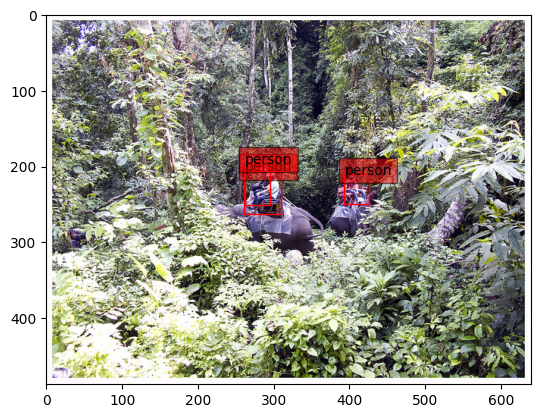

In [10]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def read_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall('object')
    labels = []
    bboxes = []
    for obj in objects:
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        labels.append(label)
        bboxes.append((xmin, ymin, xmax, ymax))
    return labels, bboxes

def plot_image_with_bbox(image_path, xml_path):
    image = Image.open(image_path)
    labels, bboxes = read_xml(xml_path)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for bbox, label in zip(bboxes, labels):
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, label, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

# Replace '000000000036.jpg' with the name of your image file
image_path = './train/data/000000000061.jpg'
# Replace 'train.xml' with the path to your train.xml file
xml_path = './train_xml/000000000061.xml'

plot_image_with_bbox(image_path, xml_path)


xmlyolo_to_txt

In [4]:
import xml.etree.ElementTree as ET
import cv2
import os
import glob

def parse_xml_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    image_path = "./" + root.find('filename').text
    objects = root.findall('object')
    boxes = []
    for obj in objects:
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        boxes.append((class_name, xmin, ymin, xmax, ymax))
    return image_path, boxes

def convert_to_yolo_format(image_width, image_height, box):
    class_name, xmin, ymin, xmax, ymax = box
    x_center = (xmin + xmax) / (2.0 * image_width)
    y_center = (ymin + ymax) / (2.0 * image_height)
    width = (xmax - xmin) / image_width
    height = (ymax - ymin) / image_height
    return f"{class_name} {x_center} {y_center} {width} {height}"

def write_yolo_data(image_path, yolo_boxes, output_file):
    with open(output_file, 'w') as f:
        for yolo_box in yolo_boxes:
            class_name, *box_info = yolo_box.split()
            class_idx = 0  # Replace with the appropriate class index for "person" class
            yolo_line = f"{class_idx} {' '.join(box_info)}\n"
            f.write(yolo_line)

image_folder_path = "train/data/"
annotation_folder_path = "train/train_xml_yolo/"
output_folder_path = "train/yolo_annotations/"  # Replace this with your desired output folder path

xml_files = glob.glob(annotation_folder_path + "*.xml")
for xml_file in xml_files:
    image_path, boxes = parse_xml_annotation(xml_file)
    image = cv2.imread(os.path.join(image_folder_path, image_path))
    image_width, image_height, _ = image.shape
    yolo_boxes = [convert_to_yolo_format(image_width, image_height, box) for box in boxes]
    txt_filename = os.path.basename(xml_file).replace(".xml", ".txt")
    output_file_path = os.path.join(output_folder_path, txt_filename)
    write_yolo_data(os.path.basename(image_path), yolo_boxes, output_file_path)

    

train_xml_yolo

In [8]:
import xml.etree.ElementTree as ET
import json
import os

def json_to_xml(json_path, xml_path, image_folder_path, target_label="person"):
    with open(json_path, 'r') as f:
        data = json.load(f)

    images = data['images']
    annotations = data['annotations']
    categories = data['categories']

    image_id_to_filename = {image['id']: image['file_name'] for image in images}
    image_id_to_annotations = {image['id']: [] for image in images}

    for ann in annotations:
        image_id = ann['image_id']
        image_id_to_annotations[image_id].append(ann)

    for image_id, filename in image_id_to_filename.items():
        image_path = os.path.join(image_folder_path, filename)
        image_annotations = image_id_to_annotations[image_id]

        root = ET.Element("annotation")

        folder = ET.SubElement(root, "folder").text = image_folder_path
        filename_xml = ET.SubElement(root, "filename").text = filename

        size = ET.SubElement(root, "size")
        width = ET.SubElement(size, "width").text = str(data['images'][0]['width'])
        height = ET.SubElement(size, "height").text = str(data['images'][0]['height'])
        depth = ET.SubElement(size, "depth").text = str(3)  # Assuming 3 channels for RGB images

        for ann in image_annotations:
            category_id = ann['category_id']
            category_name = [cat['name'] for cat in categories if cat['id'] == category_id][0]
            bbox = ann['bbox']

            if category_name == target_label:
                object_xml = ET.SubElement(root, "object")
                name = ET.SubElement(object_xml, "name").text = category_name
                bndbox = ET.SubElement(object_xml, "bndbox")

                # Normalize the bounding box coordinates
                image_width = data['images'][0]['width']
                image_height = data['images'][0]['height']
                xmin = bbox[0] / image_width
                ymin = bbox[1] / image_height
                xmax = (bbox[0] + bbox[2]) / image_width
                ymax = (bbox[1] + bbox[3]) / image_height

                xmin_elem = ET.SubElement(bndbox, "xmin").text = str(xmin)
                ymin_elem = ET.SubElement(bndbox, "ymin").text = str(ymin)
                xmax_elem = ET.SubElement(bndbox, "xmax").text = str(xmax)
                ymax_elem = ET.SubElement(bndbox, "ymax").text = str(ymax)

        if len(root.findall("object")) > 0:  # Only save the annotation if there is at least one "person" object
            tree = ET.ElementTree(root)
            tree.write(os.path.join(xml_path, os.path.splitext(filename)[0] + ".xml"))

# Example usage:
json_to_xml("val/val_labels.json", "val/val_xml_yolo/", "val/data/", target_label="person")
#json_to_xml("validation/labels.json", "validation_xml/", "validation/data/", target_label="person")


In [9]:
import os
import xml.etree.ElementTree as ET

def xml_to_yolo(xml_folder, output_folder):
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith('.xml'):
            continue

        xml_path = os.path.join(xml_folder, xml_file)
        image_id = os.path.splitext(xml_file)[0]
        txt_file = image_id + ".txt"
        output_path = os.path.join(output_folder, txt_file)

        tree = ET.parse(xml_path)
        root = tree.getroot()

        with open(output_path, 'w') as f:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name == "person":
                    class_name = "0"

                xmin = float(obj.find('bndbox/xmin').text)
                ymin = float(obj.find('bndbox/ymin').text)
                xmax = float(obj.find('bndbox/xmax').text)
                ymax = float(obj.find('bndbox/ymax').text)

                yolo_line = f"{class_name} {xmin} {ymin} {xmax} {ymax}\n"
                f.write(yolo_line)

# Example usage:
xml_folder = "for_yolo/xml_yolo"  # Replace with the path to your generated XML folder
output_folder = "for_yolo/yolo_annotations"  # Replace with the desired output folder path
xml_to_yolo(xml_folder, output_folder)
